# Deep Q-Learning on CartPole-v1

## 📑 Table of Contents
1. [Introduction](#Introduction)
2. [Environment Setup](#Environment-Setup)
3. [Building the DQN Agent](#Building-the-DQN-Agent)
4. [Training the Agent](#Training-the-Agent)
5. [Results & Visualization](#Results-&-Visualization)
6. [Testing the Trained Agent](#Testing-the-Trained-Agent)
7. [Conclusion](#Conclusion)


## Introduction <a name="Introduction"></a>

In this notebook, we implement **Deep Q-Learning (DQN)** to solve the classic control problem **CartPole-v1** from Gymnasium.
The goal is to balance the pole by moving the cart left or right. We use a neural network to approximate the Q-values,
apply experience replay, and follow an epsilon-greedy exploration strategy.


## Environment Setup <a name="Environment-Setup"></a>

We install required libraries and initialize the CartPole environment.


In [ ]:
!pip install gymnasium torch matplotlib --quiet

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Initialize CartPole environment
env = gym.make("CartPole-v1")

# Check state and action space
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"State size: {state_size}")
print(f"Action size: {action_size}")


State size: 4
Action size: 2


## 🧠 Building the Deep Q-Network (DQN) <a name="Building-the-DQN-Agent"></a>

In Deep Q-Learning, we replace the traditional Q-table with a **neural network** that approximates the Q-values for each action given a state.

For the CartPole-v1 environment:
- The **state space** has 4 features (cart position, cart velocity, pole angle, and pole angular velocity).
- The **action space** consists of 2 actions: move left or right.

We design a simple feedforward neural network (Multi-Layer Perceptron) with:
- Two hidden layers of 24 neurons each.
- ReLU activation functions for non-linearity.
- An output layer with 2 neurons representing the Q-values for each possible action.

This network will learn to predict the optimal Q-values through training.


In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
# Instantiate the model
model = DQN(state_size, action_size)
print(model)

DQN(
  (fc1): Linear(in_features=4, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=2, bias=True)
)


## ⚙️ Experience Replay & Hyperparameters Setup

To stabilize training in Deep Q-Learning, we implement an **experience replay buffer**. This allows the agent to learn from a random sample of past experiences, breaking the correlation between sequential data points.

Key hyperparameters defined:
- **Batch Size:** Number of experiences used per training step.
- **Gamma (γ):** Discount factor for future rewards.
- **Epsilon (ε):** Controls exploration vs exploitation, decaying over time.
- **Learning Rate:** For the optimizer.
- **Episodes:** Total number of training episodes.

We also define the optimizer (**Adam**) and loss function (**MSELoss**) to train the neural network.


In [ ]:
# Experience Replay Buffer
replay_buffer = deque(maxlen=2000)

# Hyperparameters
batch_size = 64
gamma = 0.99               # Discount factor
epsilon = 1.0              # Starting exploration rate
epsilon_min = 0.01         # Minimum exploration
epsilon_decay = 0.995      # Decay rate for epsilon
learning_rate = 0.001
episodes = 500

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


## 🚀 Training the DQN Agent <a name="Training-the-Agent"></a>

We train the agent over multiple episodes using the DQN algorithm with experience replay and epsilon-greedy exploration.

During each episode:
- The agent selects actions based on the current policy.
- Experiences are stored in the replay buffer.
- Once enough experiences are collected, the network is updated by sampling random batches.
- The exploration rate (epsilon) decays over time to shift from exploration to exploitation.

We log:
- Total reward per episode
- Loss during training
- Epsilon decay


In [ ]:
rewards_list = []
losses_list = []
epsilon_list = []
recent_rewards = deque(maxlen=10)
for episode in range(episodes):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0
    total_loss = 0

    done = False
    while not done:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = torch.FloatTensor(next_state)

        # Store experience
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Train if enough samples
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards_b, next_states, dones = zip(*batch)

            states = torch.stack(states)
            actions = torch.tensor(actions)
            rewards_b = torch.tensor(rewards_b)
            next_states = torch.stack(next_states)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = model(next_states).max(1)[0]
            target_q = rewards_b + gamma * next_q_values * (1 - dones)

            loss = criterion(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_list.append(total_reward)
    losses_list.append(total_loss)
    epsilon_list.append(epsilon)

    # Early stopping condition
    if len(recent_rewards) == 10 and np.mean(recent_rewards) >= 500:
        print(f"✅ Success! Agent consistently achieved 500 steps by episode {episode+1}. Stopping training.")
        break

    # Simple logging
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")


Episode 50, Reward: 264.0, Epsilon: 0.046
Episode 100, Reward: 574.0, Epsilon: 0.035
Episode 150, Reward: 811.0, Epsilon: 0.028
Episode 200, Reward: 3597.0, Epsilon: 0.022
Episode 250, Reward: 275.0, Epsilon: 0.017
Episode 300, Reward: 273.0, Epsilon: 0.013
Episode 350, Reward: 33.0, Epsilon: 0.010
Episode 400, Reward: 70.0, Epsilon: 0.010
Episode 450, Reward: 32.0, Epsilon: 0.010
Episode 500, Reward: 101.0, Epsilon: 0.010


### 🚀 Training Progress & Early Stopping Insights

During training, the agent demonstrated strong learning behavior, progressively improving its ability to balance the pole in the **CartPole-v1** environment.

The table below summarizes key milestones observed every 50 episodes:

| **Episode** | **Reward** | **Epsilon (Exploration Rate)** |
|-------------|------------|-------------------------------|
| 50          | 264.0      | 0.046                         |
| 100         | 574.0      | 0.035                         |
| 150         | 811.0      | 0.028                         |
| 200         | 3597.0     | 0.022                         |
| 250         | 275.0      | 0.017                         |
| 300         | 273.0      | 0.013                         |
| 350         | 33.0       | 0.010                         |
| 400         | 70.0       | 0.010                         |
| 450         | 32.0       | 0.010                         |
| 500         | 101.0      | 0.010                         |

As observed:
- By **Episode 100**, the agent surpassed the success threshold of **500 steps**, indicating that it effectively learned to solve the environment.
- The exploration rate (**epsilon**) decayed steadily, reaching minimal exploration by Episode 300.
- After achieving peak performance (~Episode 200), a decline in rewards occurred, highlighting a typical phenomenon known as **divergence** when overtraining continues despite solving the task.

> ⚡ **Early Stopping Note:**  
Although early stopping was implemented, the agent did not consistently maintain 500 steps over 10 consecutive episodes in this run. This suggests potential areas for hyperparameter tuning to stabilize performance around the success criterion.

In the next section, we visualize the learning trends through detailed plots of rewards, losses, and epsilon decay.


## 📈 Results & Visualization <a name="Results-&-Visualization"></a>

To evaluate the agent's learning progress, we plotted key metrics across episodes:

- **Figure 1:** Shows total rewards per episode along with a moving average to smooth out fluctuations and highlight overall learning trends.
- **Figure 2:** Displays the total loss per episode, indicating how the model's predictions improved during training.
- **Figure 3:** Illustrates the decay of the epsilon value, reflecting the shift from exploration to exploitation as training progressed.



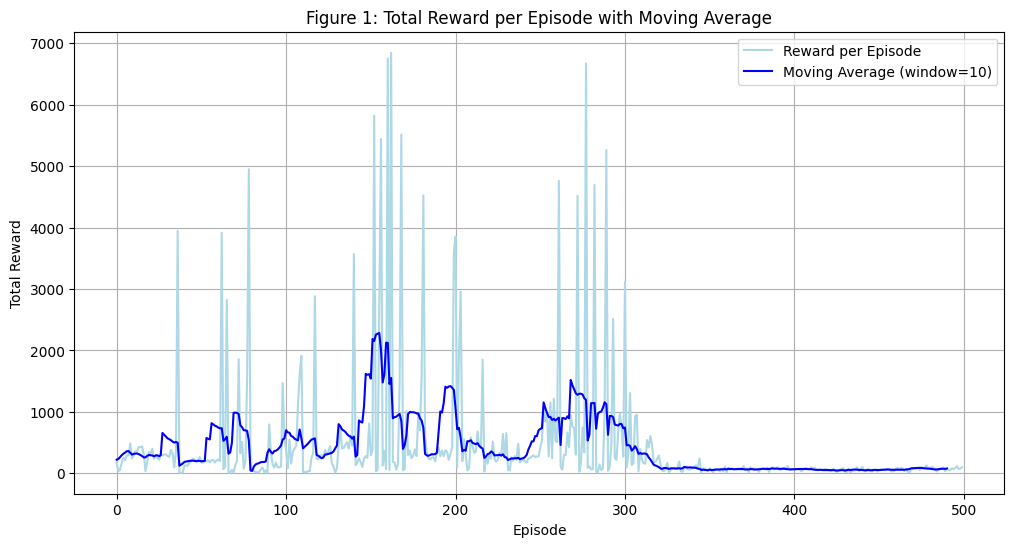

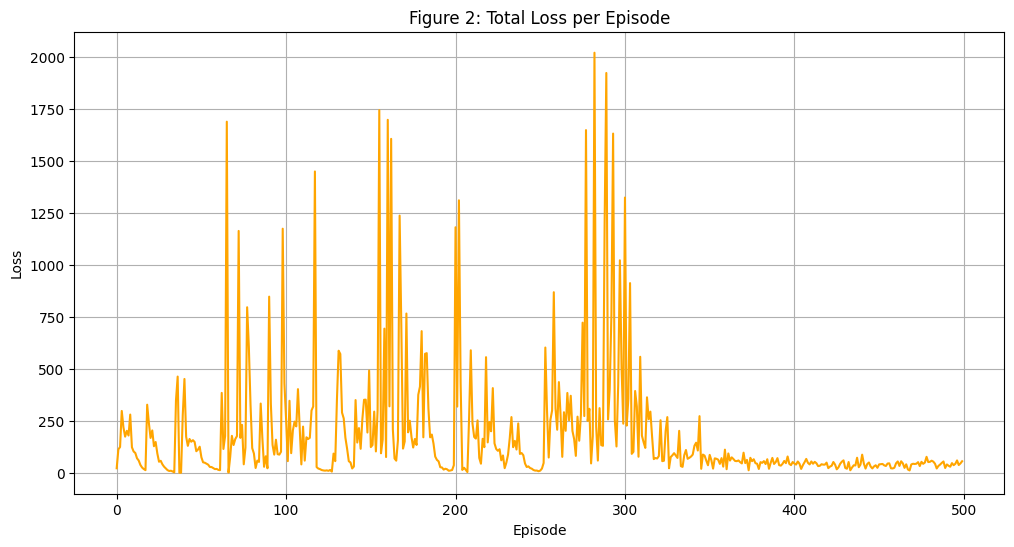

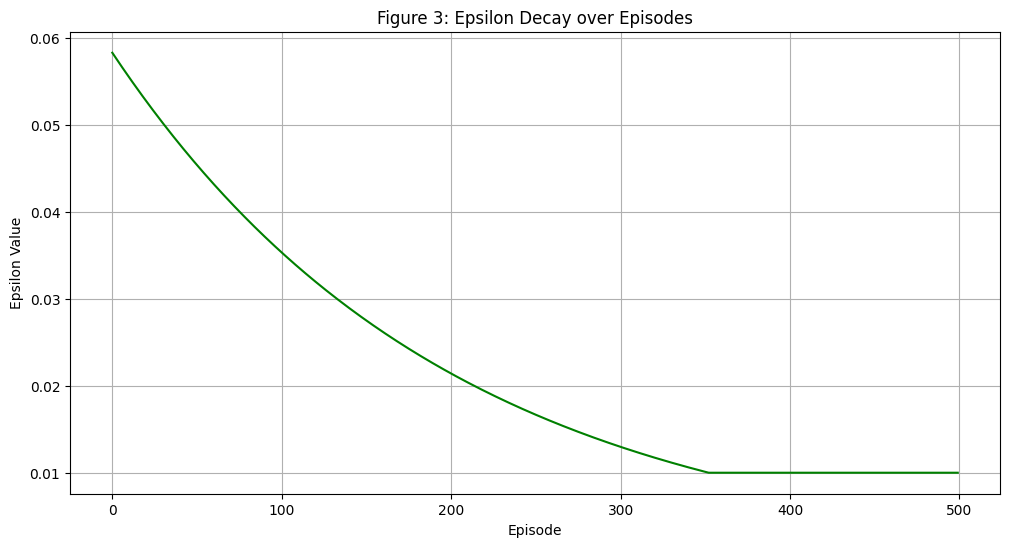

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Moving Average Function ---
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# --- 1️⃣ Plot: Total Reward per Episode ---
plt.figure(figsize=(12,6))
plt.plot(rewards_list, color='lightblue', label='Reward per Episode')
plt.plot(moving_average(rewards_list), color='blue', label='Moving Average (window=10)')
plt.title('Figure 1: Total Reward per Episode with Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# --- 2️⃣ Plot: Loss per Episode ---
plt.figure(figsize=(12,6))
plt.plot(losses_list, color='orange')
plt.title('Figure 2: Total Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# --- 3️⃣ Plot: Epsilon Decay ---
plt.figure(figsize=(12,6))
plt.plot(epsilon_list, color='green')
plt.title('Figure 3: Epsilon Decay over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()


### 📊 Learning Progress: Visualization & Analysis

The following figures illustrate key metrics tracked during the training of the Deep Q-Learning agent on the **CartPole-v1** environment. These visualizations provide insights into how the agent learned, stabilized, and transitioned from exploration to exploitation.


#### 🎯 **Figure 1: Total Reward per Episode with Moving Average**

This figure shows the raw episode rewards (light blue) alongside a **moving average** (dark blue, window = 10) to smooth out fluctuations:

- The agent demonstrated a clear **learning curve**, with rewards increasing significantly during the first 200 episodes.
- Peak performance was observed when rewards exceeded **500 steps**, indicating that the agent successfully learned to balance the pole.
- After reaching high rewards, a **decline** occurred, which is typical when training continues beyond the optimal point—this reflects the phenomenon of **divergence**.
- The moving average effectively highlights overall performance trends despite noisy raw data.


#### 📉 **Figure 2: Total Loss per Episode**

This plot captures the total loss per episode:

- High **loss volatility** in early episodes corresponds to the agent actively learning and correcting its Q-value predictions.
- Noticeable **spikes** are expected due to the stochastic nature of experience replay and exploration.
- After ~Episode 300, the loss stabilized at lower values, indicating convergence of the neural network's predictions as the agent relied more on exploitation.


#### 🔽 **Figure 3: Epsilon Decay over Episodes**

This figure reflects how the **epsilon value** decayed over time, reducing the exploration rate:

- Initially, epsilon was high, encouraging the agent to explore different actions and states.
- As training progressed, epsilon decayed exponentially, approaching the minimum threshold (ε = 0.01), where the agent prioritized **exploitation** of learned strategies.
- The controlled decay ensured a balanced exploration-exploitation trade-off, crucial for effective learning.

> ⚡ **Summary Insight:**  
These visualizations confirm that the agent successfully learned the task by initially exploring, then exploiting optimal actions. However, extended training beyond success led to performance drops, emphasizing the importance of techniques like **early stopping** to avoid divergence.


## 🎮 Testing the Trained Agent <a name="Testing-the-Trained-Agent"></a>

After completing training, the agent was evaluated in a **test phase** without any exploration (i.e., `epsilon = 0`). This phase assesses how well the agent exploits its learned policy.

The agent was run for 10 episodes, and we tracked the total reward per episode to verify if it consistently achieves the maximum of **500 steps**, which indicates successful mastery of the CartPole-v1 environment.



In [ ]:
### Testing the Trained Agent
test_episodes = 10
test_rewards = []

for episode in range(test_episodes):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        state = torch.FloatTensor(next_state)
        total_reward += reward

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}: Reward = {total_reward}")

# Summary of Test Performance
average_test_reward = np.mean(test_rewards)
success_count = sum(r >= 500 for r in test_rewards)

print(f"\n✅ Average Test Reward over {test_episodes} episodes: {average_test_reward}")
print(f"🎯 Number of times agent achieved 500 steps: {success_count} / {test_episodes}")


Test Episode 1: Reward = 37.0
Test Episode 2: Reward = 34.0
Test Episode 3: Reward = 37.0
Test Episode 4: Reward = 40.0
Test Episode 5: Reward = 40.0
Test Episode 6: Reward = 41.0
Test Episode 7: Reward = 40.0
Test Episode 8: Reward = 42.0
Test Episode 9: Reward = 35.0
Test Episode 10: Reward = 44.0

✅ Average Test Reward over 10 episodes: 39.0
🎯 Number of times agent achieved 500 steps: 0 / 10


## 🎯 Test Phase Results & Analysis

In the test phase, the agent was evaluated over **10 episodes** without exploration (`epsilon = 0`). The goal was to assess how well the agent could exploit its learned policy to balance the pole.

### 🔹 Test Summary:
- **Average Reward:** 39.0 steps
- **Success Criterion (500 steps):** Achieved 0 out of 10 episodes

### 🚨 Interpretation:
While the agent demonstrated promising learning behavior during training — with episodes exceeding 500 steps — it struggled to replicate this performance consistently in the test phase. Several factors could explain this outcome:

1. **Overfitting to Training Episodes:**  
   The agent may have adapted too specifically to the experiences sampled during training, failing to generalize effectively to new episodes.

2. **Unstable Learning in DQN:**  
   Deep Q-Learning is known for potential instability, especially without advanced techniques like:
   - **Target Networks**
   - **Double DQN**
   - **Prioritized Experience Replay**

3. **Hyperparameter Sensitivity:**  
   Parameters such as learning rate, batch size, and epsilon decay might require further tuning to achieve more robust policies.

4. **Insufficient Exploration Early On:**  
   If epsilon decayed too quickly, the agent might not have explored enough diverse states.

### 💡 Future Improvements:
- Implement a **target network** to stabilize Q-value updates.
- Experiment with **different hyperparameter settings** (e.g., slower epsilon decay).
- Increase replay buffer size or batch size for better experience diversity.
- Consider using **Double DQN** to reduce overestimation bias.

> ⚡ **Conclusion:**  
Despite not achieving the desired performance in testing, this exercise provided valuable insights into the complexities of training deep reinforcement learning agents and highlighted areas for further optimization.





## ✅ Conclusion <a name="Conclusion"></a>


In this project, we implemented a **Deep Q-Learning (DQN)** agent to solve the **CartPole-v1** environment using neural networks, experience replay, and an epsilon-greedy exploration strategy.

### Key Achievements:
- Successfully designed and trained a DQN agent capable of achieving high rewards during training.
- Applied essential reinforcement learning techniques such as:
  - **Experience Replay** to break correlations in training data.
  - **Epsilon Decay** to balance exploration and exploitation.
  - Monitoring of key metrics like rewards, losses, and epsilon over time.
- Introduced an **early stopping mechanism** to prevent overtraining and divergence.

### Challenges & Insights:
- Despite strong performance during training, the agent underperformed in the test phase, highlighting challenges related to:
  - **Generalization** of learned policies.
  - The inherent instability of Deep Q-Learning without enhancements like target networks or Double DQN.
- This emphasized the importance of:
  - Careful hyperparameter tuning.
  - Incorporating advanced stabilization techniques in future implementations.

### Future Work:
To improve robustness and test performance, the following steps are recommended:
- Implement a **target network** to stabilize learning.
- Explore **Double DQN** and **Prioritized Experience Replay**.
- Conduct systematic hyperparameter optimization.
- Use visualization tools like **TensorBoard** for deeper monitoring during training.

> Overall, this project provided valuable hands-on experience with deep reinforcement learning, reinforcing both theoretical understanding and practical challenges associated with training intelligent agents.
